<div class="alert alert-block alert-warning"> <b>Authors and Reviewers</b>. This is the notebook version for review. We will remove this markdown cell after the peer-review. </div>

<h1><center>
Learning the Underlying Physics of a Simulation Model of the Ocean's Temperature <br>
</center></h1>  
<h3><center>
Computational Reproduction of <br> "A Sensitivity Analysis of a Regression Model of Ocean Temperature"
    
</center></h3>


<h4><center>
Garima Malhotra, Daniela Pinto Veizaga and Jorge Peña

</center></h4>
    
## Context
Can data-driven models for weather and climate predictions learn the underlying physics of the system against which they are trained? Or are they simply capable of identifying statistical patterns without any clear link to the underlying physics? Furner, R. at al. (2022) run a sensitivity analysis of a regression-based model of ocean temperature, trained against simulations from a 3D ocean model setup, demostrating that regression models are capable of learning much of the physics of the underlying system.
    


![Ocean Temperature](https://www.commondreams.org/media-library/ocean-surface-temperatures.jpg?id=33699188&width=1200&height=400&quality=90&coordinates=0%2C667%2C0%2C667)

<p><center>
Source: Image generated by the NASA and taken from Common Dreams.
</center></p>


## Purpose
This notebook aims to complement the science and methodological development embedded within the original paper, using an open infrastructure that allows users to combine interactive code with text and graphical objects, translating research outputs into findable, accessible, interoperable and reusable outputs and code.

### Description
This notebook demonstrates the inputs, the training of the regression model of ocean temperature and its sensitivity analysis.

### Highlights
+ Load and install the necessary libraries and dependencies to run this notebook, i.e., numpy, xarray, etc.
+ Set up the structure of the project.
+ Download the original dataset used for training the regression models.
+ Visualize the simulator outputs and inspect the temperature distributions near the equator,  the poles, and the deep ocean.
+ Showcase an example of model training for linear regression.
+ Evaluate the performance of the regressors.
+ Inspect the spatial distribution of the averaged errors.
+ Perform a sensitivity analysis and run a series of withholding experiments.
+ Summarize our findings.
+ Provide contact information.

## Contributions

### Notebook
 - Garima Malhotra, University of Colorado Boulder, [@garimamalhotra](https://github.com/garimamalhotra)
 - Daniela Pinto Veizaga, University of California, Berkeley, [@dapivei](https://github.com/dapivei) 
 - Jorge Eduardo Peña Velasco, Claremont McKenna College, [@jedpe](https://github.com/jedpe)

### Modeling Codebase
- Rachel Furner, University of Cambridge, Cambridge, [@RachelFurner](https://github.com/RachelFurner/) (Original Creator)
- Garima Malhotra, University of Colorado Boulder, [@garimamalhotra](https://github.com/garimamalhotra)(Contributor)
- Daniela Pinto Veizaga, University of California, Berkeley, [@dapivei](https://github.com/dapivei) (Contributor) 
- Jorge Eduardo Peña Velasco, Claremont McKenna College, [@jedpe](https://github.com/jedpe) (Contributor)

### Modeling publications
- Furner, R., Haynes, P., Munday, D., Paige, B., Jones, D., & Shuckburgh, E. (2022). A sensitivity analysis of a regression model of ocean temperature. Environmental Data Science, 1, E11. doi:10.1017/eds.2022.10

### Data
Furner, Rachel. (2021). MITgcm Dataset for paper: Sensitivity analysis of a data-driven model of ocean temperature (v1.1) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.7919172

Malhotra, Garima, Pinto-Veizaga, Daniela, & Pena, Jorge. (2023). Reproducible Challenge - Team 3 - Sensitivity analysis- Models. https://doi.org/10.5281/zenodo.7954232

### Source Code

The authors of the notebook acknowledge the original creator for providing public code available at [Regression Model OceanTemp](https://github.com/RachelFurner/RegressionModelOceanTemp). An updated and enhaced version of the code is available at [Reproducibility of "A sensitivity analysis of a regression model of ocean temperature"](https://github.com/garimamalhotra/repro-challenge-team-3.).


<div class="alert alert-block alert-info"> <b>Note</b> Significant parts from source code were adapted or written from scratch for this notebook and the reproducible challenge. </div>


## Update Conda Environment

In [1]:
# Run this notebook in a Conda environment and update the libraries
#!conda env update --quiet --file '../environment.yml'

## Load libraries
List libraries according to their role e.g. system/files manipulation i.e. os (first), data handling i.e. numpy, xarray (second), visualisation i.e. holoviews (third), etc. The cell below contains two libraries, `os` and `warning` which are common among the Python Jupyter notebooks. Don't remove them.*

In [2]:
# System imports
import os
import gc
import sys

# Custom functions from the authors' repo
sys.path.append("../src/general/")
sys.path.append('../src/pipelines/')
import CreateDataName as cn
import AssessModel as am
import plotting as rfplt
import ReadRoutinesModified as rr

# Custom functions of the reproducibility team
from constants import *


# Modeling
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV

# Data handling
import gzip
import pickle
import numpy as np
import xarray as xr

# Plotting
import matplotlib.pyplot as plt

## Set project structure
*The cell below creates a separate folder to save the notebook outputs. This facilitates the reader to inspect inputs/outputs stored within a defined destination folder. Don't remove the lines below.*

In [3]:
notebook_folder = './notebook'
if not os.path.exists(notebook_folder):
    os.makedirs(notebook_folder)

## Dataset

The training and validation data derive from running the Massachusetts Institute of Technology general circulation model ([MITgcm](https://zenodo.org/record/4672260#.ZFgb_S-B2pY)) —a physically based model capable of simulating the ocean or the atmosphere dynamics due to isomorphisms in the governing equations. This research project relies on a simple 2° sector configuration that captures the fundamental dynamics of the ocean, including a realistic overturning circulation. This configuration features a single ocean basin, with:
+ limited topography, 
+ simplified coastlines, and 
+ constant idealized forcing. 

The domain runs from 60°S to 60° N, and is just over 20° wide in longitude. The domain is bounded by land along its northern and southern edges, and a strip of land runs along the eastern/western boundary from 60° N to 40° S.  Below this, in the southernmost 20°, the simulator has a periodic boundary condition, allowing flow that exits to the east and west to return to the domain at the western and eastern boundary. The domain has flat-bottom bathymetry of 5,000 m over most of the domain, with a 2° region of 2,500-m depth at the southernmost 20° of the eastern edge.

The simulator has:

+ 42 depth levels, with the surface layer being the thinnest at 10 m, and the bottom 10 levels being the maximum at 250 m. + 11 cells in the longitudinal direction, and
+ 78 cells in the latitudinal direction.

The simulator has a 12-hr time step, with fields output daily. We focus on daily-mean outputs.


## Download

To download the original dataset, available [here](https://zenodo.org/record/7919172). This dataset is used to train the regression model described in the paper. To download this data locally, run the following line of code. This process will take $\sim 1$ hour.

In [4]:
%%time
!bash "../infrastructure/downloader.sh" > "../outputs/logs/download_data.txt"

Title: Reproducible Challenge - Team 3 - Sensitivity analysis- Models
Keywords: 
Publication date: 2023-05-21
DOI: 10.5281/zenodo.7954232
Total size: 20016.8 MB

Link: https://zenodo.org/api/files/7fd9d4ed-5531-4a81-b374-35b391d8911a/MODELS.tar.gz   size: 3.3 MB

Checksum is correct. (332d414b58c98fdc7a13ad333ecfced4)

Link: https://zenodo.org/api/files/7fd9d4ed-5531-4a81-b374-35b391d8911a/predictions.tar.gz   size: 5084.1 MB

Checksum is correct. (f46951915a69ee94d15a167273a307a9)

Link: https://zenodo.org/api/files/7fd9d4ed-5531-4a81-b374-35b391d8911a/trunc_io_arrays.tar.gz   size: 14929.4 MB

Checksum is correct. (57f356b65c31e76ed5a27dd32f6053b8)
All files have been downloaded.
CPU times: user 21.1 s, sys: 3.95 s, total: 25 s
Wall time: 25min 8s


### Overview of the Ocean Dynamics (Figure 1)

The paper uses a  2°
  sector configuration to simulate ocean dynamics. This configuration features a single ocean basin, with limited topography, simplified coastlines, and constant idealized forcing. This has been used in a number of idealized simulations of Southern Ocean processes and their impacts on the global circulation. This configuration, while relatively simple, captures the fundamental dynamics of the ocean, including a realistic overturning circulation.

The domain runs from  60°𝑆
  to  60°𝑁
 , and is just over  20°
  wide in longitude. The domain is bounded by land along the northern (and southern) edge, and a strip of land runs along the eastern (and western) boundary from  60°
  N to  40°𝑆
  (see Figure 1a). Below this, in the southernmost 20°, the simulator has a periodic boundary condition, allowing flow that exits to the east (west) to return to the domain at the western (eastern) boundary. The domain has flat-bottom bathymetry of 5,000 m over most of the domain, with a 2° region of 2,500-m depth at the southernmost 20° of the eastern edge (i.e., the spit of land forming the eastern boundary continues to the southern boundary as a 2,500-m high subsurface ridge).

* Input variables are - temperature, salinity, U (East–West) and V (North–South) current components, density, U, V, and W (vertical) components of the GM bolus velocities, sea surface height (SSH), latitude, longitude, and depth. 
* The GM bolus velocities are a parameterization of the velocities resulting from ocean eddies and are used in the GM scheme to calculate the advective effects of eddy action on tracers. 


 LOADING MITGCM DATASET 


Reading in MITGCM dataset ...
Shape of dataset: (2, 42, 78, 11)


 25 M BELOW THE SURFACE FOR ONE PARTICULAR DAY 


Temperature (°C) at 25 m below the surface for one particular day.


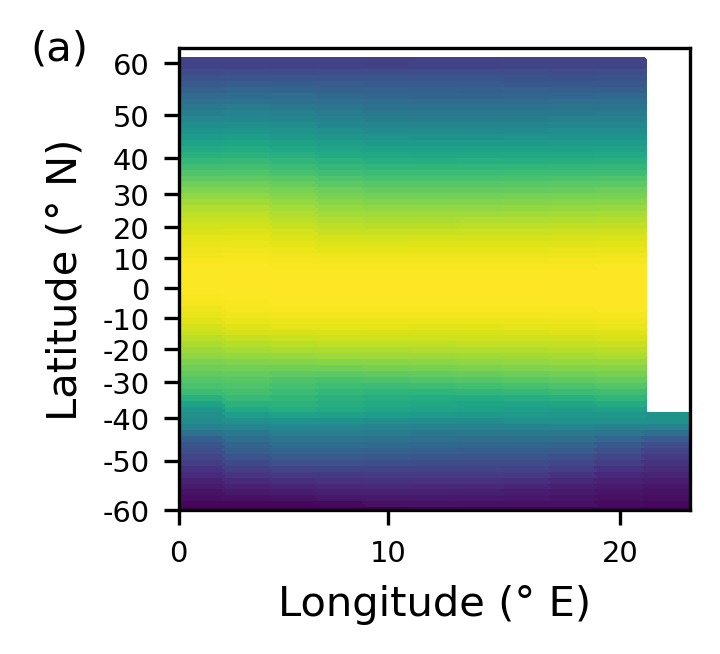

<Figure size 640x480 with 0 Axes>

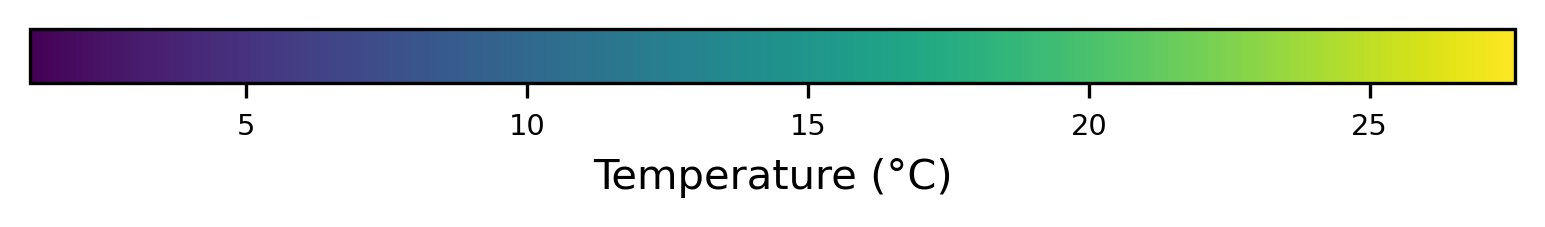

Change in temperature between over 1 day at 25 m below the surface.


<Figure size 640x480 with 0 Axes>

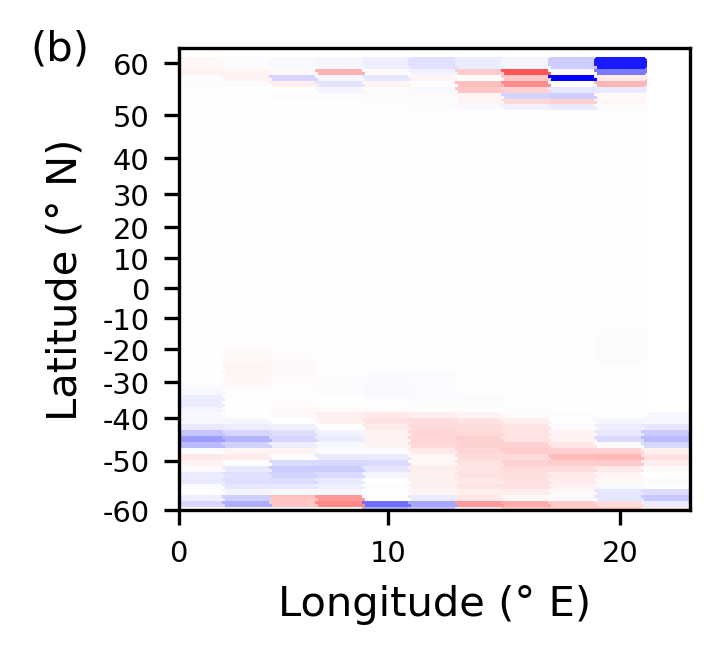

<Figure size 640x480 with 0 Axes>

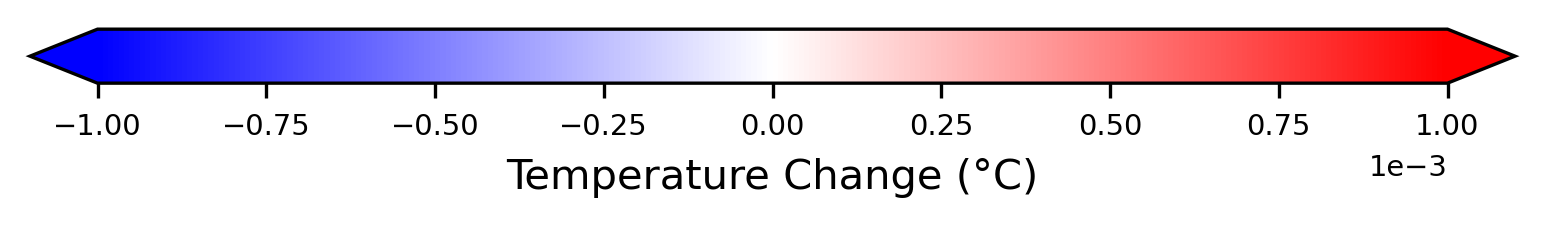

Standard deviation in temperature at 25 m below the surface.


<Figure size 640x480 with 0 Axes>

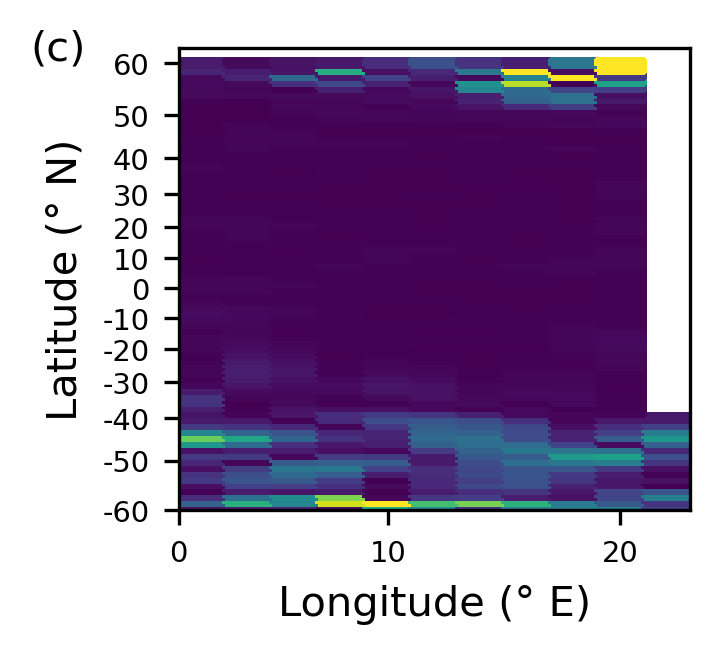

<Figure size 640x480 with 0 Axes>

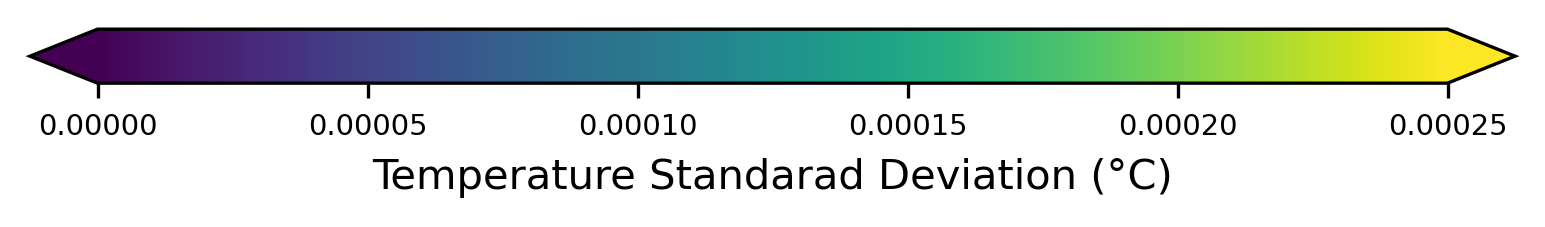


 25 M BELOW THE SURFACE & AT at 13° E FOR ONE PARTICULAR DAY 


Temperature (°C) at 25 m below the surface & at 13° E for one particular day.


<Figure size 640x480 with 0 Axes>

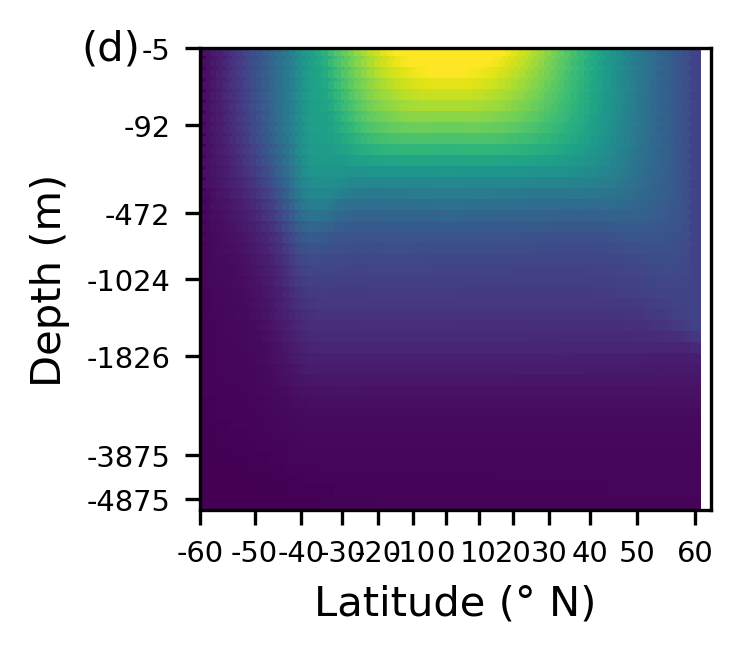

Change in temperature between over 1 day in temperature at 25 m below the surface & at 13° E.


<Figure size 640x480 with 0 Axes>

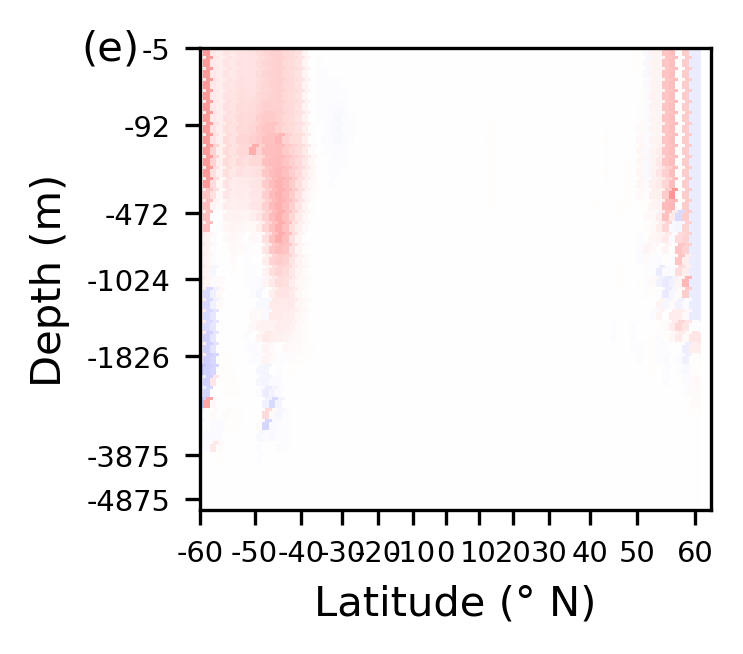

Standard deviation in temperature at 25 m below the surface & at 13° E.


<Figure size 640x480 with 0 Axes>

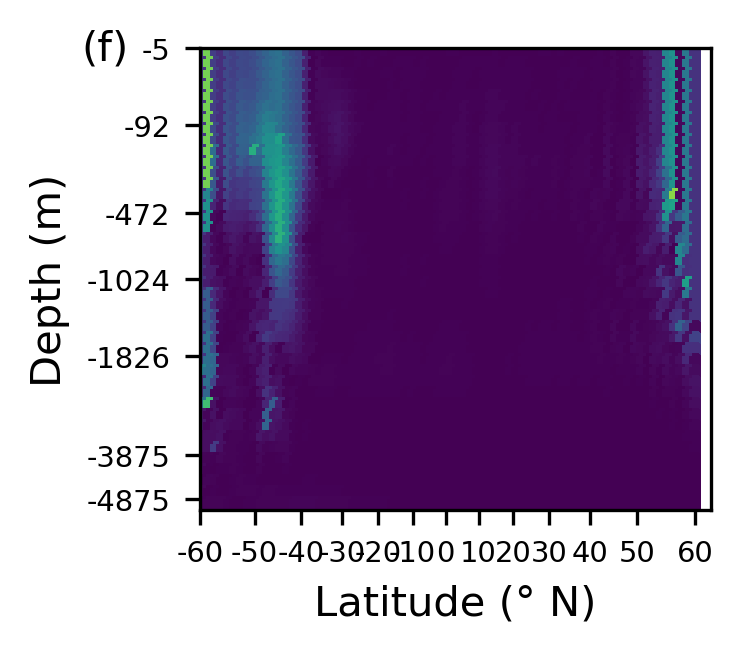


  TIME SERIES AT 57° N, 17° E, and −25 m 




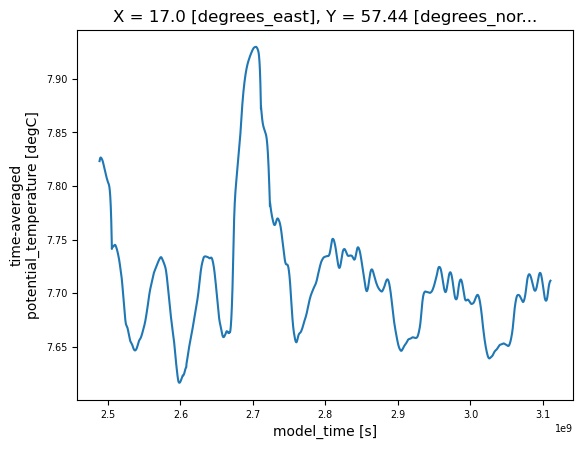


  TIME SERIES AT 55° S, 9° E, and −25 m 




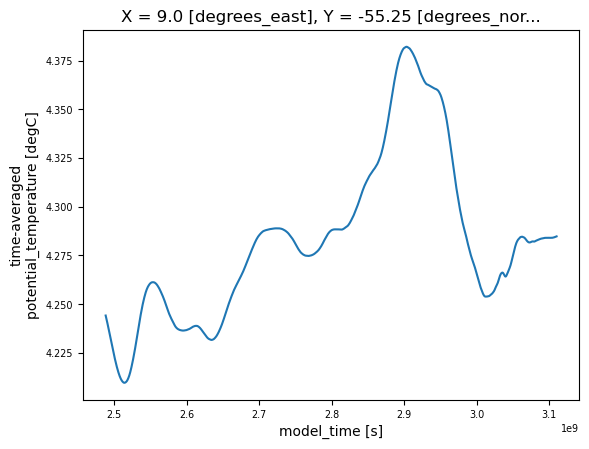

In [5]:
%run "../src/pipelines/graphs_section.py"

Note that the depth axis is scaled to give each GCM grid cell equal spacing. The simulator shows a realistic temperature distribution with warm surface water near the equator, and cooler water near the poles and in the deep ocean. Temperature changes are largest in the very north of the domain and throughout the southern region. Though changes per day are small, they accumulate over time to give cycles of around 0.2° in some regions of the domain.

## Model training
Training of the model was performed for the purely linear regression model (only linear terms) and the nolinear regression model (linear and multiplicative terms). Run parameters for the control and withholding experiments were set through the `run_vars` variable in the script `../src/pipelines/TrainLinearRegressionModel.py`.

### Linear regression example

Let's start by setting the run parameters for a linear regression model with all inputs. To run the linear regression model, the `poly_degree` key must be set to `1`.

In [6]:
# Run parameters
run_vars = {
    'dimension':3, 
    'lat':True , 
    'lon':True ,
    'dep':True , 
    'current':True , 
    'bolus_vel':True ,
    'sal':True , 
    'eta':True , 
    'density':True , 
    'poly_degree':1,
    'StepSize':1, 
    'predict':'DelT'
}

# Name of the model based on the run parameters"
model_prefix = "alpha.001_"
data_prefix = ""
data_name = data_prefix + cn.create_dataname(run_vars)
model_name = model_prefix + data_name
print(f"Model name: {model_name}")

Model name: alpha.001_3dLatLonDepUVBolSalEtaDnsPolyDeg1_Step1_PredictDelT


In [7]:
# Read in data
MITGCM_filename = os.path.join(data_raw_path, "cat_tave.nc")
density_file = os.path.join(data_raw_path, "DensityData.npy")
clim_filename = os.path.join(data_raw_path, "ncra_cat_tave.nc")

norm_inputs_tr, norm_inputs_val, norm_inputs_te, \
norm_outputs_DelT_tr, norm_outputs_DelT_val, \
norm_outputs_DelT_te, norm_outputs_Temp_tr, norm_outputs_Temp_val, \
norm_outputs_Temp_te, orig_temp_tr, orig_temp_val, clim_temp_tr, \
clim_temp_val = rr.ReadMITGCM(
    MITGCM_filename, 
    clim_filename, 
    density_file,
    0.7, 
    0.9,
    data_name, 
    run_vars, 
    plot_histograms=False
)
                            
norm_outputs_tr = norm_outputs_DelT_tr
norm_outputs_val = norm_outputs_DelT_val

# Free some memory
del norm_inputs_te
del norm_outputs_DelT_te
del norm_outputs_Temp_te
gc.collect()

(18000, 42, 78, 11)
0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
6000
6200
6400
6600
6800
7000
7200
7400
*********************************
Number of training & validation samples > 0.0005: [171979], [52235]
Number of training & validation samples > 0.001:  [111033], [34604]
Number of training & validation samples > 0.002:  [82846], [25565]
Number of training & validation samples > 0.0025: [76097], [23495]
Number of training & validation samples > 0.003:  [70810], [22054]
Number of training & validation samples > 0.004:  [62849], [19632]
Number of training & validation samples > 0.005:  [56885], [17853]
*********************************
highest and lowest values in training data:   0.26704645, -0.23875284
highest and lowest values in validation data: 0.23960555, -0.26727915
mean of train and val sets : -5.388849e-05, 0.0001357027
std  of train and val sets : 0.01036672, 0.011045901
skew of 

18811

#### Model fit example

Train the model with hyperparameter $\alpha = 0.001$.

In [8]:
# Model hyperparameters for the grid search
alpha_s = [0.001]
parameters = [{'alpha': alpha_s}]
n_folds=3

lr = linear_model.Ridge(fit_intercept=False)

lr = GridSearchCV(
    lr, 
    param_grid=parameters, 
    cv=n_folds, 
    scoring='neg_mean_squared_error', 
    refit=True
)

# Fit the model
lr.fit(norm_inputs_tr, norm_outputs_tr)
lr.get_params()

{'cv': 3,
 'error_score': nan,
 'estimator__alpha': 1.0,
 'estimator__copy_X': True,
 'estimator__fit_intercept': False,
 'estimator__max_iter': None,
 'estimator__normalize': 'deprecated',
 'estimator__positive': False,
 'estimator__random_state': None,
 'estimator__solver': 'auto',
 'estimator__tol': 0.001,
 'estimator': Ridge(fit_intercept=False),
 'n_jobs': None,
 'param_grid': [{'alpha': [0.001]}],
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': 'neg_mean_squared_error',
 'verbose': 0}

### Performance of the Regressor

#### Scatter Plot for the Control Regressor (Figure 2) - Different from above

In [9]:
#Setting up the parameters for the run 
run_vars = {'dimension':3, 'lat':True , 'lon':True , 'dep':True , 'current':True , 'bolus_vel':True , 'sal':True , 'eta':True , 'density':True , 'poly_degree':2, 'StepSize':1, 'predict':'DelT'}
data_name = data_prefix + cn.create_dataname(run_vars)
model_name = model_prefix+data_name
pkl_filename='../outputs/models/' + model_name+'_pickle.pkl'

In [10]:
print('Loading : ', pkl_filename)
with open(pkl_filename, 'rb') as file:
    print('opening '+pkl_filename)
    lr = pickle.load(file)

Loading :  ../outputs/models/alpha.001_3dLatLonDepUVBolSalEtaDnsPolyDeg2_Step1_PredictDelT_pickle.pkl
opening ../outputs/models/alpha.001_3dLatLonDepUVBolSalEtaDnsPolyDeg2_Step1_PredictDelT_pickle.pkl


In [11]:
#loading input arrays - These are the processed input vectors with all the 
# polynomial input features
path='../data/interim/'
inputs_tr_filename = path+'trunc_SinglePoint_'+data_name+'_InputsTr.npy'
inputs_val_filename = path+'trunc_SinglePoint_'+data_name+'_InputsVal.npy'
inputs_te_filename = path+'trunc_SinglePoint_'+data_name+'_InputsTe.npy'
outputs_tr_DelT_filename = path+'SinglePoint_'+data_name+'_OutputsDelTTr.npy'
outputs_val_DelT_filename = path+'SinglePoint_'+data_name+'_OutputsDelTVal.npy'
outputs_te_DelT_filename = path+'SinglePoint_'+data_name+'_OutputsDelTTe.npy.gz'
outputs_tr_Temp_filename = path+'SinglePoint_'+data_name+'_OutputsTempTr.npy'
outputs_val_Temp_filename = path+'SinglePoint_'+data_name+'_OutputsTempVal.npy'
outputs_te_Temp_filename = path+'SinglePoint_'+data_name+'_OutputsTempTe.npy.gz'
orig_tr_Temp_filename = path+'SinglePoint_'+data_name+'_OrigTemp_Tr.npy'
orig_val_Temp_filename = path+'SinglePoint_'+data_name+'_OrigTemp_Val.npy'
clim_tr_Temp_filename = path+'SinglePoint_'+data_name+'_ClimTemp_Tr.npy'
clim_val_Temp_filename = path+'SinglePoint_'+data_name+'_ClimTemp_Val.npy'

In [12]:
#Loading Input Arrays
norm_inputs_tr=np.load(inputs_tr_filename)
norm_inputs_val=np.load(inputs_val_filename)
norm_inputs_te=np.load(inputs_te_filename)

In [13]:
#Loading Output Arrays- Plotting for only the first 15000 points because of memory overhead
norm_outputs_tr_DelT=np.load(outputs_tr_DelT_filename)[:15000]
norm_outputs_val_DelT=np.load(outputs_val_DelT_filename)[:15000]
norm_outputs_te_DelT=np.load(gzip.GzipFile(outputs_te_DelT_filename,'r'))[:15000]

In [14]:
norm_outputs_tr_Temp=np.load(outputs_tr_Temp_filename)[:15000]
norm_outputs_val_Temp=np.load(outputs_val_Temp_filename)[:15000]
norm_outputs_te_Temp=np.load(gzip.GzipFile(outputs_te_Temp_filename,'r'))[:15000]

In [15]:
#Loading persistence arrays to calculate climatology
orig_tr_Temp=np.load(orig_tr_Temp_filename)[:15000]
orig_val_Temp=np.load(orig_val_Temp_filename) [:15000]
clim_tr_Temp=np.load(clim_tr_Temp_filename)[:15000]
clim_val_Temp=np.load(clim_val_Temp_filename)[:15000]

In [16]:
orig_tr_Temp.shape

(15000, 1)

In [17]:
norm_inputs_tr.shape

(15000, 26106)

In [18]:
if run_vars['predict'] == 'DelT':
    norm_outputs_tr  = norm_outputs_tr_DelT
    norm_outputs_val = norm_outputs_val_DelT

elif run_vars['predict'] == 'Temp':
    norm_outputs_tr = norm_outputs_tr_Temp
    norm_outputs_val = norm_outputs_val_Temp

In [19]:
# predict values
print('predict values')
norm_lr_predicted_tr = lr.predict(norm_inputs_tr).reshape(-1,1).astype('float64')
norm_lr_predicted_val = lr.predict(norm_inputs_val).reshape(-1,1).astype('float64')

predict values


In [20]:
norm_lr_predicted_tr.shape

(15000, 1)

In [21]:
# Read in mean and std
path='../data/interim/'
mean_std_file = path+'SinglePoint_'+data_name+'_MeanStd.npz'
zip_mean_std_file = mean_std_file+'.gz' 
if os.path.isfile(mean_std_file):
       mean_std_data = np.load(mean_std_file)
elif os.path.isfile(zip_mean_std_file):
       os.system("gunzip %s" % (zip_mean_std_file))
       mean_std_data = np.load(mean_std_file)
       os.system("gunzip %s" % (mean_std_file))
input_mean  = mean_std_data['arr_0']
input_std   = mean_std_data['arr_1']
output_DelT_mean = mean_std_data['arr_2']
output_DelT_std  = mean_std_data['arr_3']
output_Temp_mean = mean_std_data['arr_4']
output_Temp_std  = mean_std_data['arr_5']

if run_vars['predict'] == 'DelT':
       output_mean = output_DelT_mean
       output_std = output_DelT_std
elif run_vars['predict'] == 'Temp':
       output_mean = output_Temp_mean
       output_std = output_Temp_std

In [22]:
# define denormalising function
def denormalise_data(norm_data,mean,std):
    denorm_data = norm_data * std + mean
    return denorm_data

In [23]:
# denormalise the predictions and true outputs   
denorm_lr_predicted_tr = denormalise_data(norm_lr_predicted_tr, output_mean, output_std)
denorm_lr_predicted_val = denormalise_data(norm_lr_predicted_val, output_mean, output_std)
denorm_outputs_tr = denormalise_data(norm_outputs_tr, output_mean, output_std)
denorm_outputs_val = denormalise_data(norm_outputs_val, output_mean, output_std)

In [24]:
#------------------
# Assess the model
#------------------
# Calculate 'persistance' score - persistence prediction is just zero everywhere as we're predicting the trend
predict_persistance_tr = np.zeros(denorm_outputs_tr.shape)
predict_persistance_val = np.zeros(denorm_outputs_val.shape)

In [25]:
top    = max(max(denorm_outputs_tr), max(denorm_lr_predicted_tr), max(denorm_outputs_val), max(denorm_lr_predicted_val))
top    = top + 0.1*abs(top)
bottom = min(min(denorm_outputs_tr), min(denorm_lr_predicted_tr), min(denorm_outputs_val), min(denorm_lr_predicted_val))
bottom = bottom - 0.1*abs(top)

### Predictions against truth for Training datasets for the control regressor.

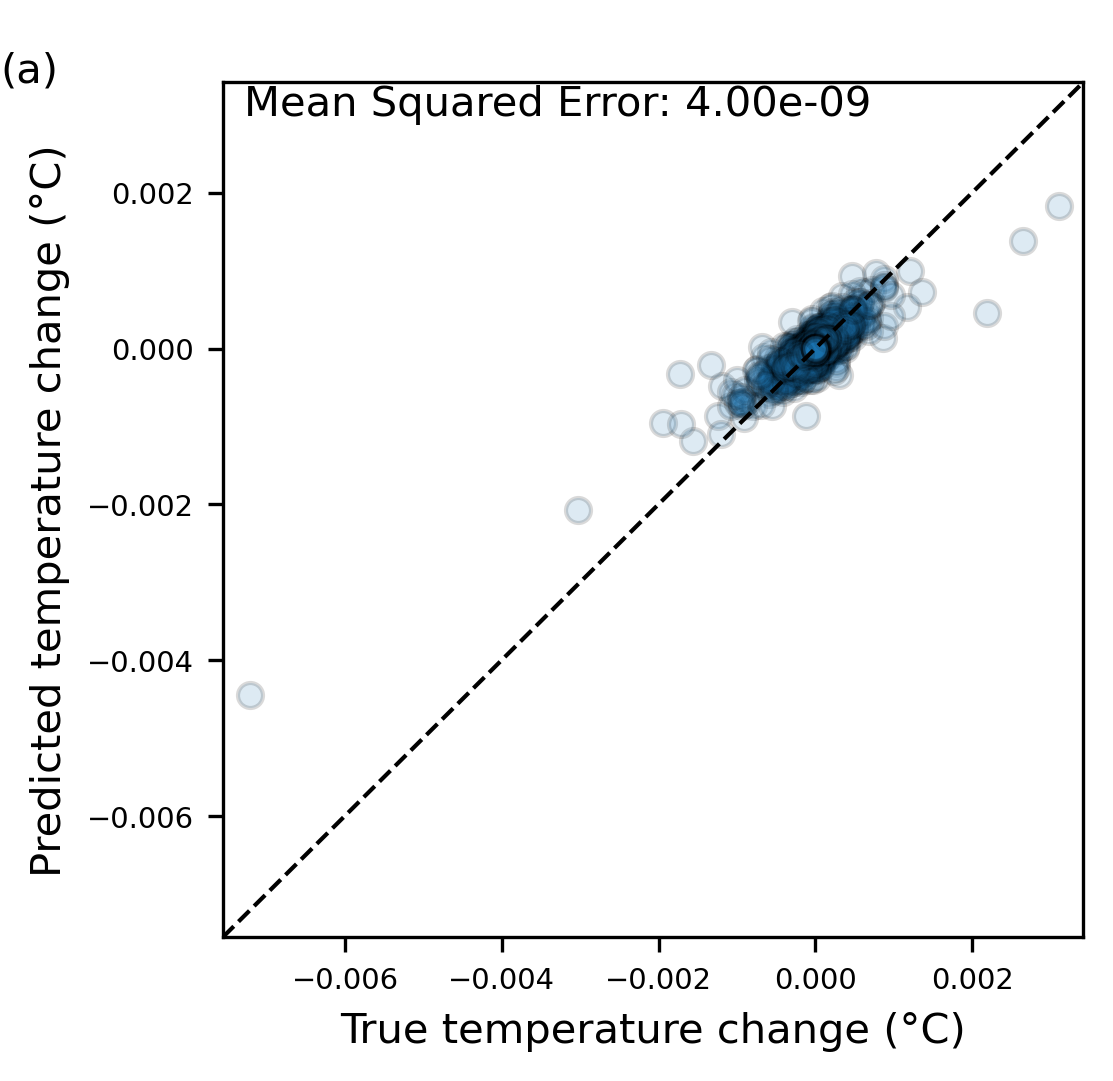

In [26]:
am.plot_scatter(model_name, denorm_outputs_tr, denorm_lr_predicted_tr, name='train', top=top, bottom=bottom, text='(a)',save=False)

### Predictions against truth for Validation datasets for the control regressor.

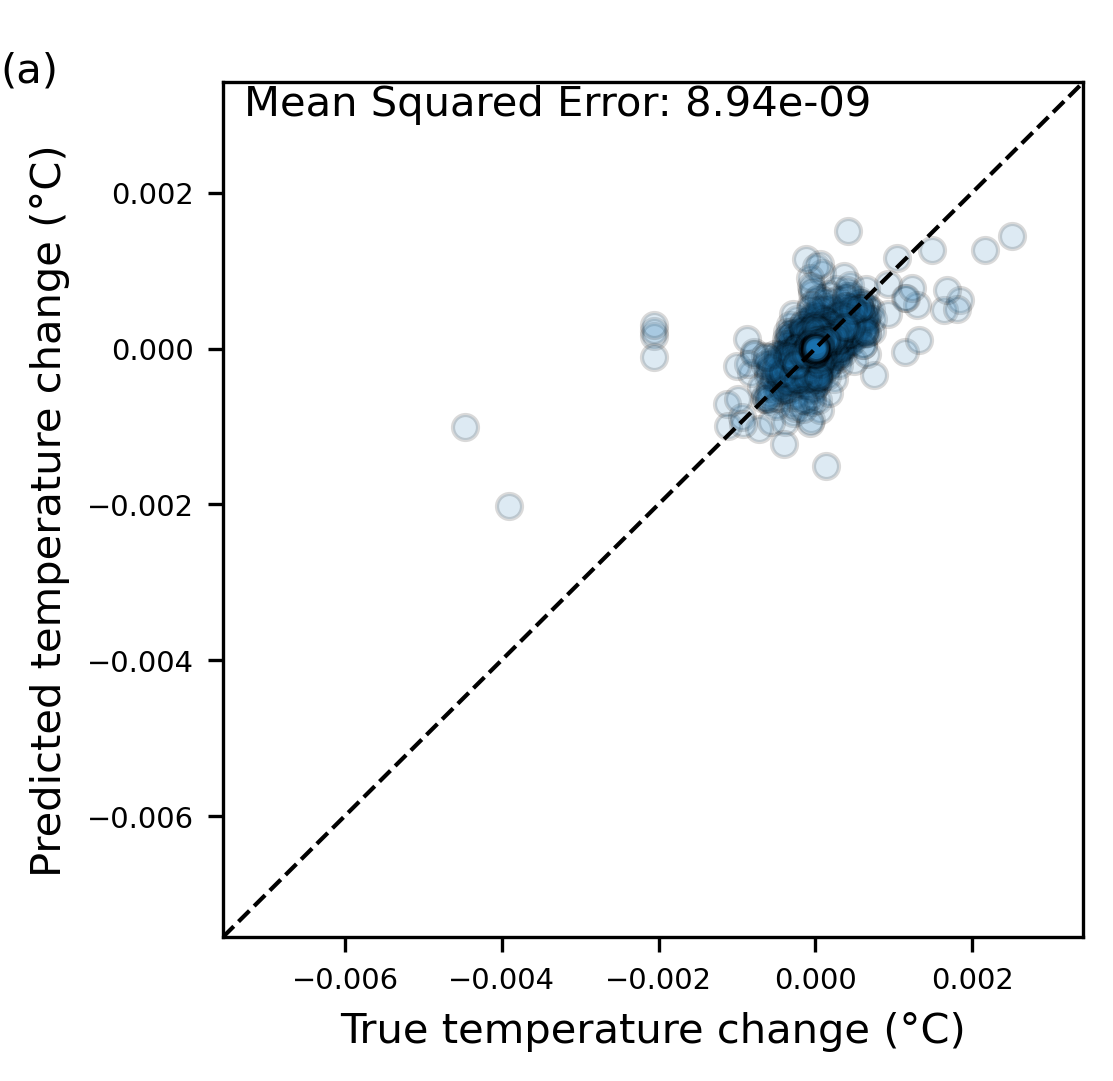

In [27]:
am.plot_scatter(model_name, denorm_outputs_val, denorm_lr_predicted_val, name='Validation', top=top, bottom=bottom, text='(a)',save=False)

The model captures the central part of the distribution well. While the majority of the temperature change is dominated by small near-zero changes, capturing these is key to producing a good forecast system. To a lesser extent, the regressor also captures the tails of the distribution, where temperature changes are larger, although the underprediction is more significant here. However, it is noteworthy that the model still shows some skill for these points, given that the model used is very simple and there are a relatively limited number of training samples in the tails

#### Spatial patterns of errors (Figure 3)

These averaged errors are shown in Figure 3. Note that the regressor is only applied away from boundary and land points (in its current form, it cannot deal with spatial locations that are not surrounded on all sides by ocean points); hence, points close to land are not included in these plots.

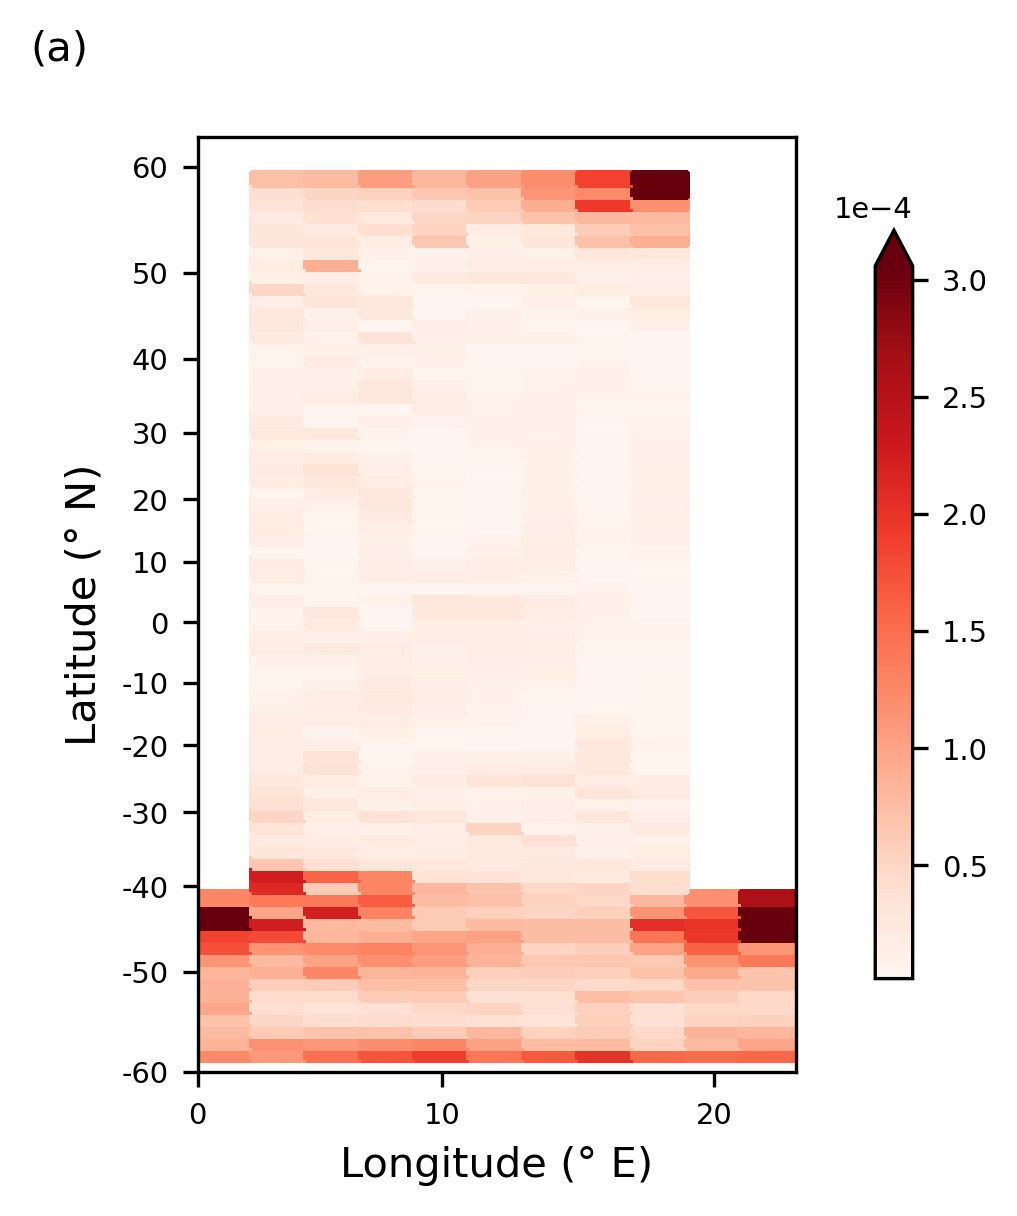

<Figure size 640x480 with 0 Axes>

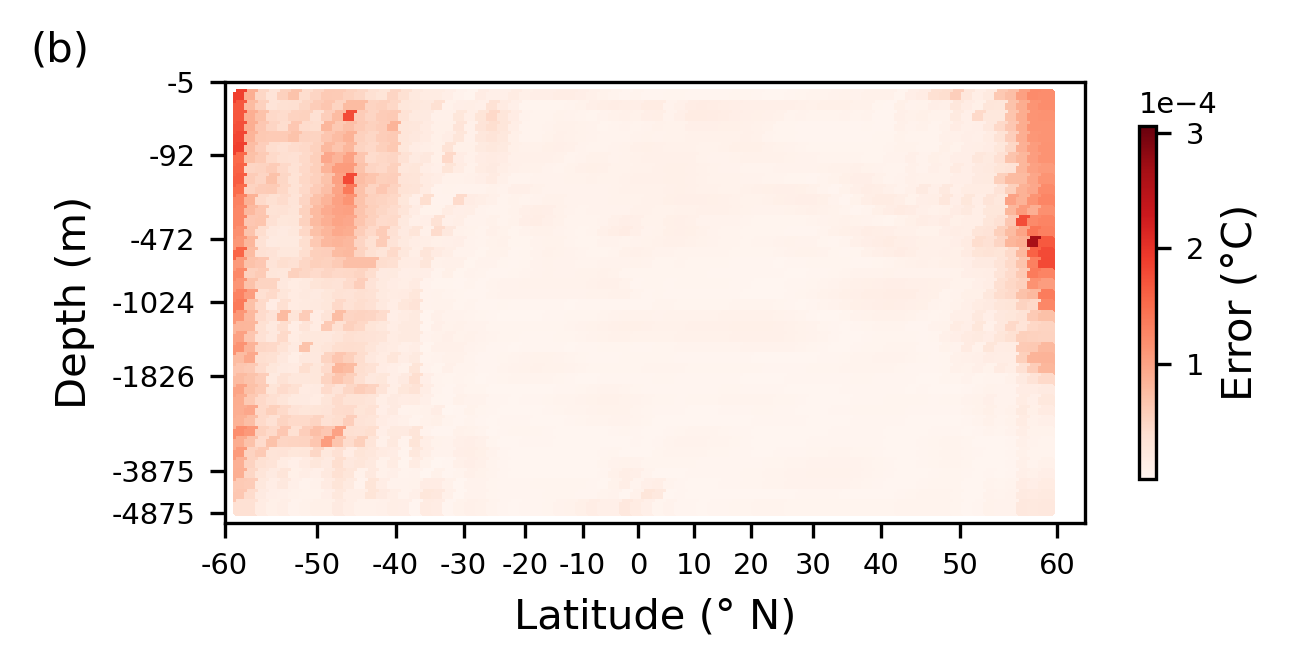

<Figure size 640x480 with 0 Axes>

In [28]:
%run "../src/pipelines/spatial_patterns_errors.py"

The regressor shows the largest errors are located in the north of the domain and in the Southern Ocean. We see that the errors in the north of the domain are co-located with regions of high vertical advective temperature fluxes, and regions of high convective fluxes. These results imply the regression model struggles to fully capture the vertical processes, and the associated heat flux, in the north of the domain. The high errors in the Southern Ocean are again co-located with regions of high vertical diffusive fluxes, this time both explicit and implicit, and vertical advection.  Throughout the ocean interior where temperature changes and the fluxes associated with these are small, errors are also small as would be expected.

## Senstivity Analysis - Coefficient Analysis

### Coefficient analysis
Figure 4a shows coefficients averaged over all input locations for each variable type (i.e., for most variables, there are 27 inputs, corresponding to the 27 neighboring cells; we average over these to give a single value for each variable (temperature, salinity, etc.) and for each polynomial combination of variables). Figure 4b shows the coefficients related to polynomial interactions of temperature with temperature—these are the raw coefficients, without any averaging applied.

../outputs/models/alpha.001_3dLatLonDepUVBolSalEtaDnsPolyDeg2_Step1_PredictDelT_coefs.npz
raw_coeffs.shape
(1, 26106)
raw_coeffs.shape
(1, 26106)


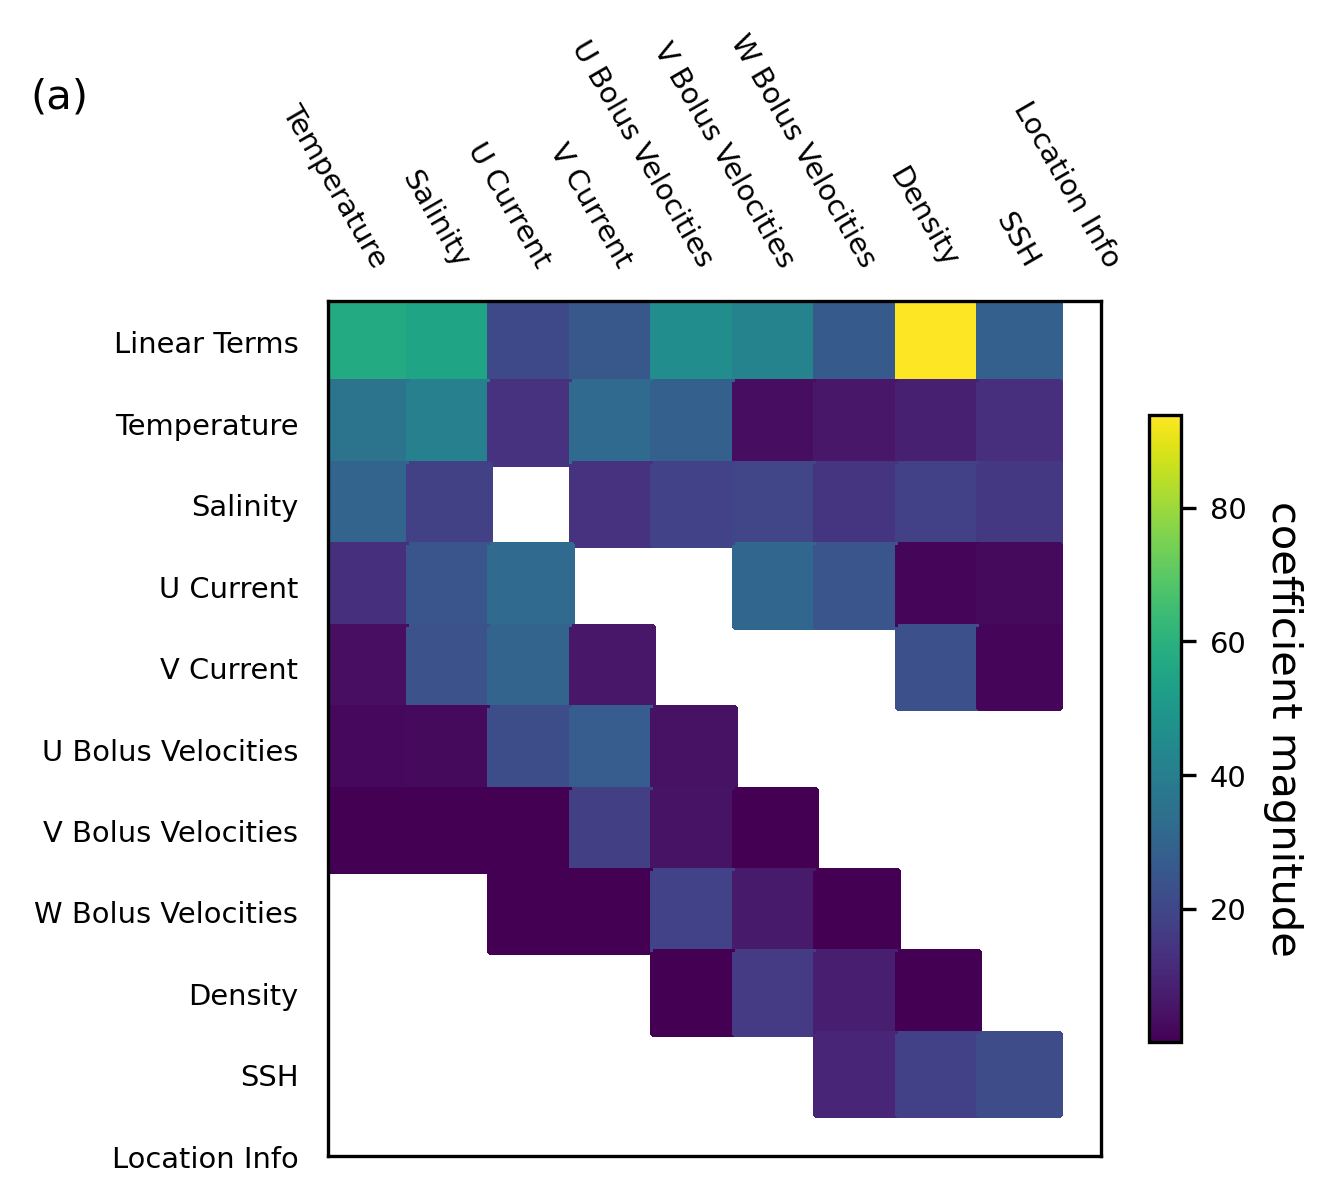

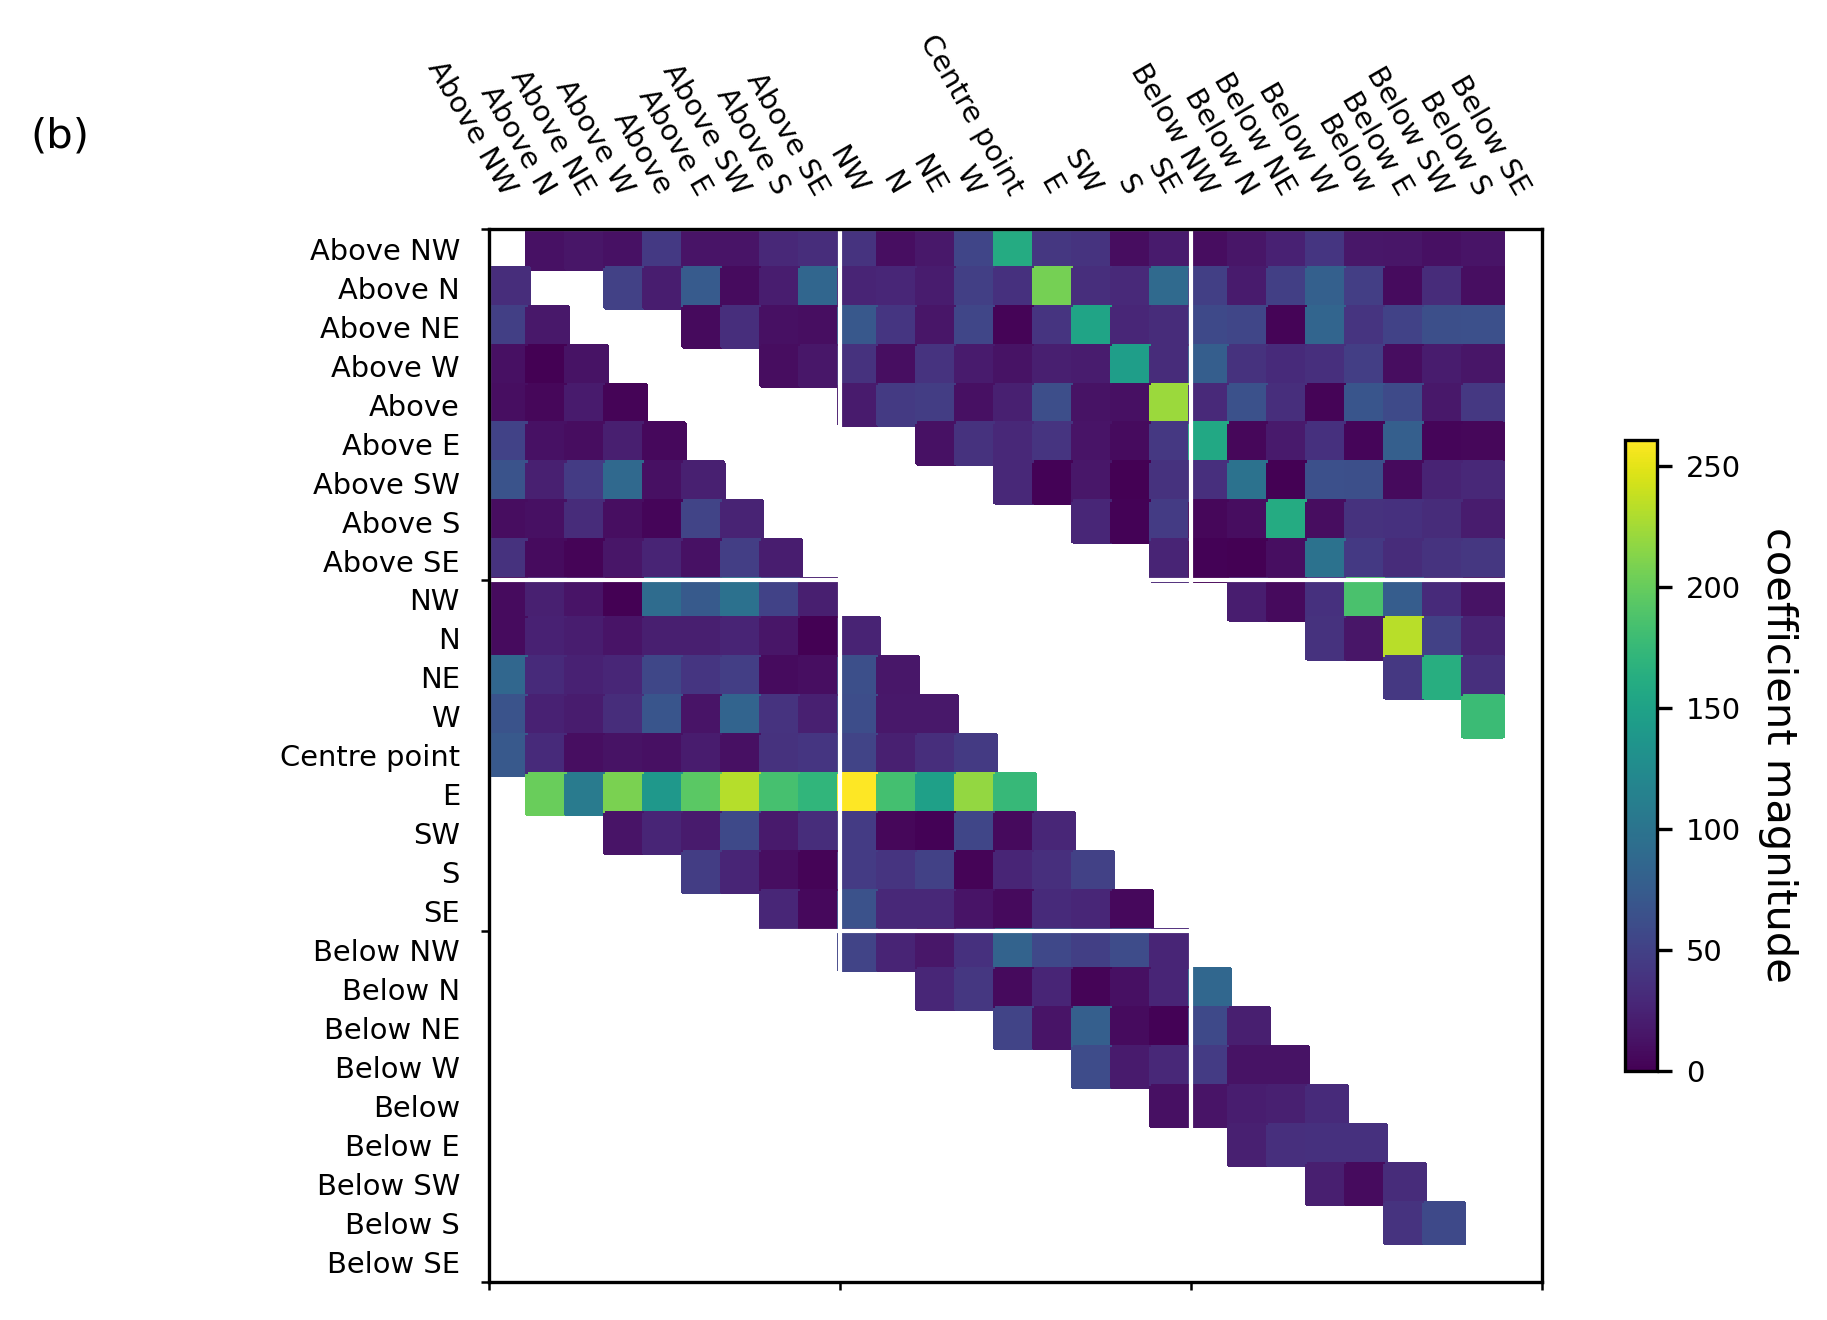

In [29]:
%run "../src/pipelines/coecien_analysis.py"

### Witholding Experiments

In this section, we run a series of withholding experiments. For each of the variables described with the exception of temperature, we train a new regressor leaving out that one variable group, for example, we train a new regressor with all the existing inputs except for salinity at all surrounding points and any multiplicative terms including salinity.

### Withholding multiplicative terms: Figure 5; Importance of Non-Linearity

In [30]:
#Setting up the parameters for the run - Setting Polynomial Degree=2
run_vars = {'dimension':3, 'lat':True , 'lon':True , 'dep':True , 'current':True , 'bolus_vel':True , 'sal':True , 'eta':True , 'density':True , 'poly_degree':1, 'StepSize':1, 'predict':'DelT'}
data_name = data_prefix + cn.create_dataname(run_vars)
model_name = model_prefix+data_name
pkl_filename='../outputs/models/' + model_name+'_pickle.pkl'

In [31]:
print('Loading : ', pkl_filename)

Loading :  ../outputs/models/alpha.001_3dLatLonDepUVBolSalEtaDnsPolyDeg1_Step1_PredictDelT_pickle.pkl


In [32]:
with open(pkl_filename, 'rb') as file:
    print('opening '+pkl_filename)
    lr = pickle.load(file)

opening ../outputs/models/alpha.001_3dLatLonDepUVBolSalEtaDnsPolyDeg1_Step1_PredictDelT_pickle.pkl


In [33]:
print('Loaded : ', model_name)

Loaded :  alpha.001_3dLatLonDepUVBolSalEtaDnsPolyDeg1_Step1_PredictDelT


In [34]:
#loading input arrays - These are the processed input vectors with all the 
# polynomial input features
path='../data/interim/'
inputs_tr_filename = path+'SinglePoint_'+data_name+'_InputsTr.npy'
inputs_val_filename = path+'SinglePoint_'+data_name+'_InputsVal.npy'
inputs_te_filename = path+'SinglePoint_'+data_name+'_InputsTe.npy.gz'
outputs_tr_DelT_filename = path+'SinglePoint_'+data_name+'_OutputsDelTTr.npy'
outputs_val_DelT_filename = path+'SinglePoint_'+data_name+'_OutputsDelTVal.npy'
outputs_te_DelT_filename = path+'SinglePoint_'+data_name+'_OutputsDelTTe.npy.gz'
outputs_tr_Temp_filename = path+'SinglePoint_'+data_name+'_OutputsTempTr.npy'
outputs_val_Temp_filename = path+'SinglePoint_'+data_name+'_OutputsTempVal.npy'
outputs_te_Temp_filename = path+'SinglePoint_'+data_name+'_OutputsTempTe.npy.gz'
orig_tr_Temp_filename = path+'SinglePoint_'+data_name+'_OrigTemp_Tr.npy'
orig_val_Temp_filename = path+'SinglePoint_'+data_name+'_OrigTemp_Val.npy'
clim_tr_Temp_filename = path+'SinglePoint_'+data_name+'_ClimTemp_Tr.npy'
clim_val_Temp_filename = path+'SinglePoint_'+data_name+'_ClimTemp_Val.npy'

In [35]:
#Loading Input Arrays
norm_inputs_tr=np.load(inputs_tr_filename)
norm_inputs_val=np.load(inputs_val_filename)
norm_inputs_te=np.load(gzip.GzipFile(inputs_te_filename,'r'))

In [36]:
#Loading Output Arrays
norm_outputs_tr_DelT=np.load(outputs_tr_DelT_filename)
norm_outputs_val_DelT=np.load(outputs_val_DelT_filename)
norm_outputs_te_DelT=np.load(gzip.GzipFile(outputs_te_DelT_filename,'r'))

In [37]:
norm_outputs_tr_Temp=np.load(outputs_tr_Temp_filename)
norm_outputs_val_Temp=np.load(outputs_val_Temp_filename)
norm_outputs_te_Temp=np.load(gzip.GzipFile(outputs_te_Temp_filename,'r'))

In [38]:
#Loading persistence arrays to calculate climatology
orig_tr_Temp=np.load(orig_tr_Temp_filename)
orig_val_Temp=np.load(orig_val_Temp_filename) 
clim_tr_Temp=np.load(clim_tr_Temp_filename)
clim_val_Temp=np.load(clim_val_Temp_filename)

In [39]:
if run_vars['predict'] == 'DelT':
       norm_outputs_tr  = norm_outputs_tr_DelT
       norm_outputs_val = norm_outputs_val_DelT

elif run_vars['predict'] == 'Temp':
       norm_outputs_tr = norm_outputs_tr_Temp
       norm_outputs_val = norm_outputs_val_Temp

In [40]:
# predict values
print('predict values')
norm_lr_predicted_tr = lr.predict(norm_inputs_tr).reshape(-1,1).astype('float64')
norm_lr_predicted_val = lr.predict(norm_inputs_val).reshape(-1,1).astype('float64')

predict values


In [41]:
norm_lr_predicted_tr.shape

(648440, 1)

In [42]:
# Read in mean and std
path='../data/interim/'
mean_std_file = path+'SinglePoint_'+data_name+'_MeanStd.npz'
zip_mean_std_file = mean_std_file+'.gz' 
if os.path.isfile(mean_std_file):
       mean_std_data = np.load(mean_std_file)
elif os.path.isfile(zip_mean_std_file):
       os.system("gunzip %s" % (zip_mean_std_file))
       mean_std_data = np.load(mean_std_file)
       os.system("gunzip %s" % (mean_std_file))
input_mean  = mean_std_data['arr_0']
input_std   = mean_std_data['arr_1']
output_DelT_mean = mean_std_data['arr_2']
output_DelT_std  = mean_std_data['arr_3']
output_Temp_mean = mean_std_data['arr_4']
output_Temp_std  = mean_std_data['arr_5']

if run_vars['predict'] == 'DelT':
       output_mean = output_DelT_mean
       output_std = output_DelT_std
elif run_vars['predict'] == 'Temp':
       output_mean = output_Temp_mean
       output_std = output_Temp_std

In [43]:
# define denormalising function
def denormalise_data(norm_data,mean,std):
    denorm_data = norm_data * std + mean
    return denorm_data

In [44]:
# denormalise the predictions and true outputs   
denorm_lr_predicted_tr = denormalise_data(norm_lr_predicted_tr, output_mean, output_std)
denorm_lr_predicted_val = denormalise_data(norm_lr_predicted_val, output_mean, output_std)
denorm_outputs_tr = denormalise_data(norm_outputs_tr, output_mean, output_std)
denorm_outputs_val = denormalise_data(norm_outputs_val, output_mean, output_std)

In [45]:
#------------------
# Assess the model
#------------------
# Calculate 'persistance' score - persistence prediction is just zero everywhere as we're predicting the trend
predict_persistance_tr = np.zeros(denorm_outputs_tr.shape)
predict_persistance_val = np.zeros(denorm_outputs_val.shape)

In [46]:
top    = max(max(denorm_outputs_tr), max(denorm_lr_predicted_tr), max(denorm_outputs_val), max(denorm_lr_predicted_val))
top    = top + 0.1*abs(top)
bottom = min(min(denorm_outputs_tr), min(denorm_lr_predicted_tr), min(denorm_outputs_val), min(denorm_lr_predicted_val))
bottom = bottom - 0.1*abs(top)

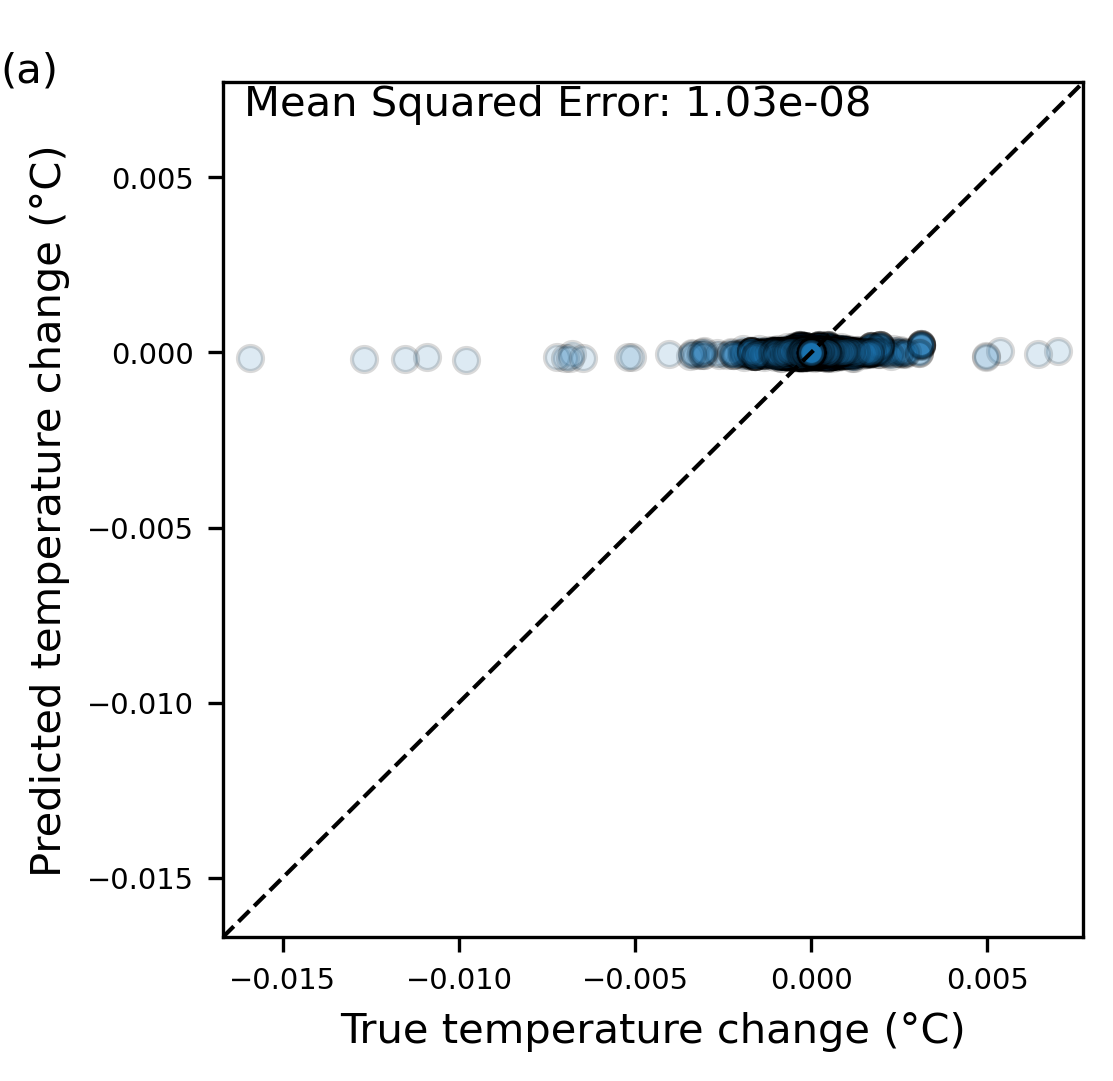

In [47]:
am.plot_scatter(model_name, denorm_outputs_tr, denorm_lr_predicted_tr, name='train', top=top, bottom=bottom, text='(a)',save=False)

We see that, without multiplicative terms, the model can capture the mean behavior of the system (zero change in temperature) but is unable to capture any of the variability. This mean behavior alone does not provide useful forecasts, as can be seen from the statistics for this experiment. 
 Nonlinearity is shown to be critical to modeling the variability of temperature change.

### Withholding 3D structure: Figure 6, Impact of vertical structure

To assess how information about the vertical structure of the ocean impacts predictions, we look at spatially averaged errors from the model trained with only a 2D neighborhood of inputs, along with the difference in error between this and the control regressor from previous Section

In [48]:
#-------------------
# Read in land mask 
#-------------------
MITGCM_ds = xr.open_dataset(MITGCM_filename)
land_mask = MITGCM_ds['Mask'].values
da_T = MITGCM_ds['Ttave'].values

In [49]:
#Loading the 2D model 
run_vars={'dimension':2, 'lat':True , 'lon':True, 'dep':True , 'current':True , 'bolus_vel':True , 'sal':True , 'eta':True , 'density':True , 'poly_degree':2, 'StepSize':1, 'predict':'DelT'}
data_name = data_prefix + cn.create_dataname(run_vars)
model_name = model_prefix+data_name
exp_name = exp_prefix+model_name
cntrl_name = exp_prefix+model_prefix+data_prefix+'3dLatLonDepUVBolSalEtaDnsPolyDeg2_Step1_PredictDelT'

In [50]:
exp_name

'alpha.001_2dLatLonDepUVBolSalEtaDnsPolyDeg2_Step1_PredictDelT'

Loading absolute errors from predictions across the grid at 500 different times averaged to give a spatial pattern of errors.

In [51]:
#------------------------
print('reading in data')
#------------------------

data_filename=pred_path+exp_name+'_AveragedSinglePredictions.nc'
ds = xr.open_dataset(data_filename)
da_Av_Error=ds['Av_Errors'].values
da_Av_AbsError=ds['Av_AbsErrors'].values
da_wtd_Av_Error=ds['Weighted_Av_Errors'].values
da_CC=ds['Cor_Coef'].values

cntrl_filename = pred_path+cntrl_name+'_AveragedSinglePredictions.nc'
cntrl_ds = xr.open_dataset(cntrl_filename)
da_cntrl_Av_AbsError=cntrl_ds['Av_AbsErrors'].values
da_cntrl_CC=cntrl_ds['Cor_Coef'].values

reading in data


In [52]:
#Plotting Cross-section at 13 degrees East
point = [ 2, 8, 6]
level = point[0]
y_coord = point[1]
x_coord = point[2]

In [53]:
# mask data
Av_Error = np.where(land_mask==1, da_Av_Error, np.nan)
Av_AbsError = np.where(land_mask==1, da_Av_AbsError, np.nan)
wtd_Av_Error = np.where(land_mask==1, da_wtd_Av_Error, np.nan)
Cntrl_Av_AbsError = np.where(land_mask==1, da_cntrl_Av_AbsError, np.nan)
Cor_Coef = np.where(land_mask==1, da_CC, np.nan)
Cntrl_Cor_Coef = np.where(land_mask==1, da_cntrl_CC, np.nan)

In [54]:
z_size = Av_Error.shape[0]
y_size = Av_Error.shape[1]
x_size = Av_Error.shape[2]

print('Av_Error.shape')
print(Av_Error.shape)

Av_Error.shape
(42, 78, 11)


Plotting the absolute error from predictions across the grid at 500 different times averaged to give a spatial pattern of errors. 

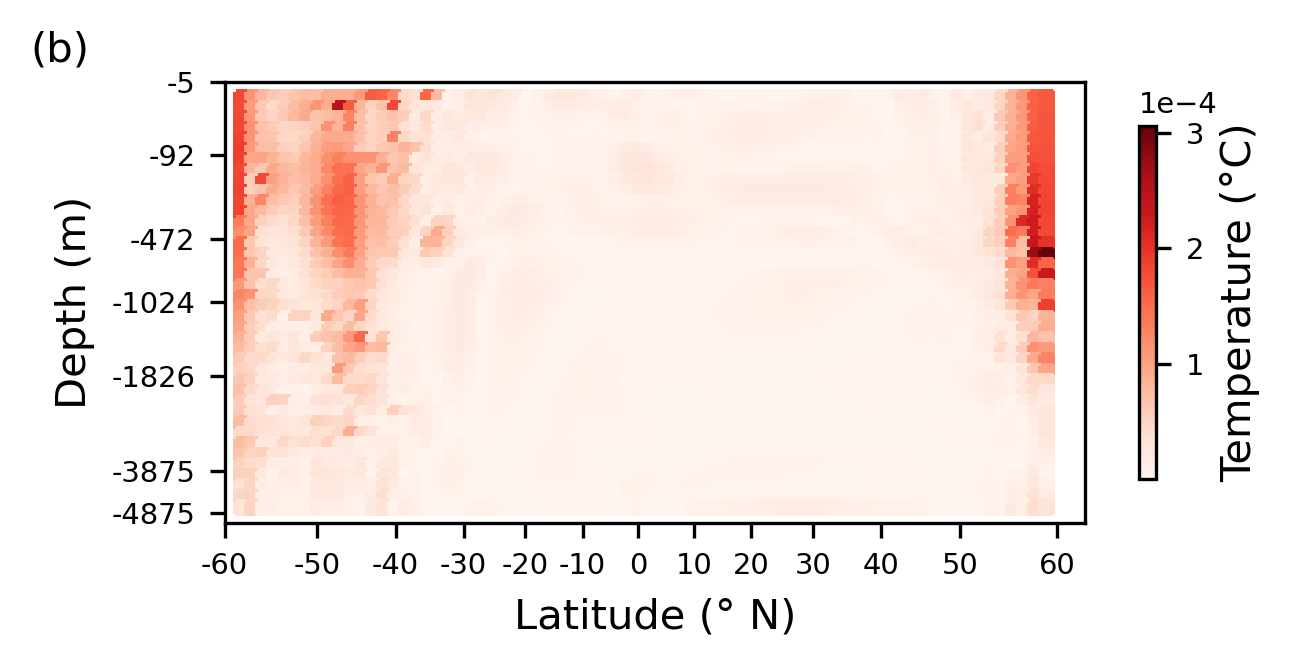

In [55]:
fig, ax, im = rfplt.plot_xconst_crss_sec(Av_AbsError[:,:,:], 'Averaged Absolute Errors', x_coord,
                                         MITGCM_ds['X'].values, MITGCM_ds['Y'].values, MITGCM_ds['Z'].values,
                                         text='(b)', title=None, min_value=0.0, max_value=0.000306, cmap='Reds',
                                         #text='(a)', title=None, min_value=0.0, max_value=0.000306, cmap='Reds',
                                         cbar_label=cbar_label, Sci=True)

Plotting the difference between this and the control run, with areas shaded in red indicating where the error has increased as a consequence of withholding information about the vertical structure, and blue indicating areas where the predictions are improved.

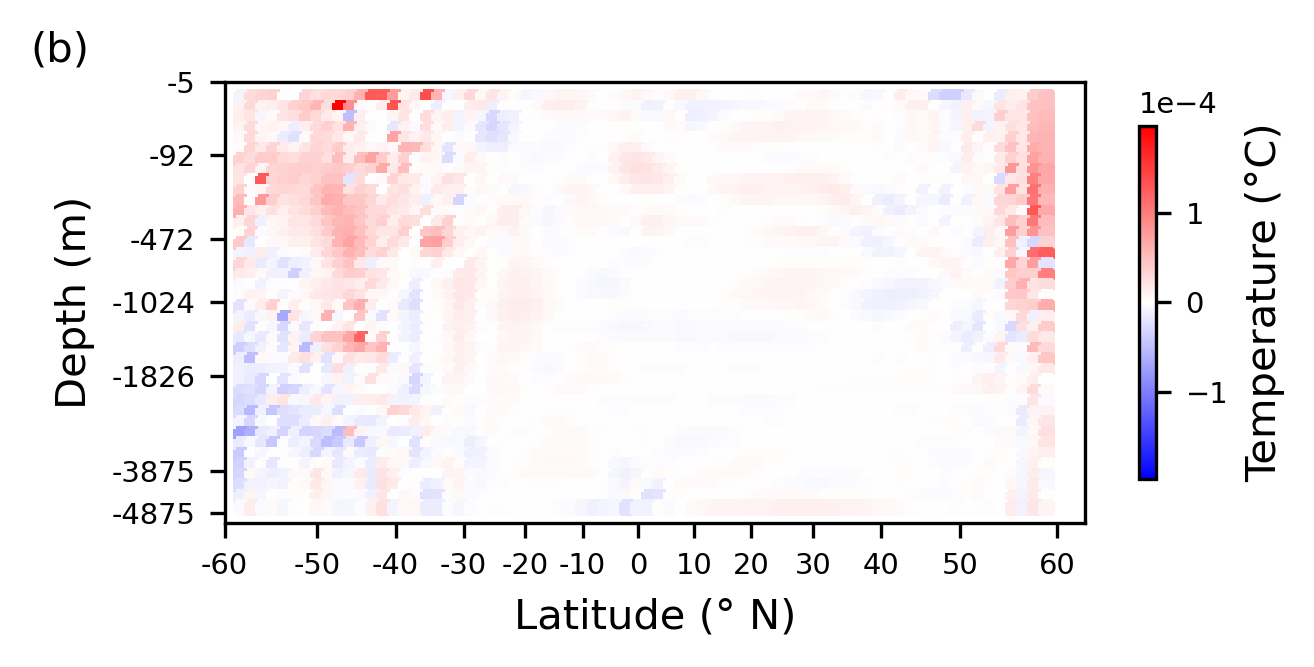

In [56]:
#Plot x cross section of difference between cntrl and exp
fig, ax, im = rfplt.plot_xconst_crss_sec(Av_AbsError[:,:,:]-Cntrl_Av_AbsError, 'Diff in Averaged Absolute Errors with Control Run', x_coord,
                                         MITGCM_ds['X'].values, MITGCM_ds['Y'].values, MITGCM_ds['Z'].values,
                                         text='(b)', title=None, min_value=None, max_value=None, diff=True,
                                         cbar_label=cbar_label, Sci=True)
#plt.savefig(figs_path+model_name+'/'+exp_name+'_AvAbsErrors_DiffwCntrl_x'+str(x_coord)+'.eps', bbox_inches = 'tight', pad_inches = 0.1, format='eps')

Interestingly, this regressor shows some regions (the deep water in the south of the domain) where the errors are notably improved in a regressor using only 2D information. In this work, we have developed a regressor which learns one equation to be applied across all grid boxes in the domain. We optimize for best performance averaged over all relevant grid cells, but this does not enforce the best possible performance over each individual grid point/region, and so some of the resultant models will favor certain types of dynamics more than others. Given this, it is not unexpected that the new equations discovered for the withholding experiments (which again optimize for best performance averaged over the entire domain interior) may outperform the control in some locations, despite being poorer overall. Here, we see that the control model is able to perform well across the domain, and optimizes for good performance overall, rather than the much more varied performance seen in the withholding experiments. It seems that as the model which withholds vertical information is not capable of performing well in many regions of the domain, a solution is found which highly optimizes performance in other regions to minimize error overall.

### Withholding Currents: Figure 7, Impact of currents

In [57]:
#Setting the run parameters
run_vars={'dimension':3, 'lat':True , 'lon':True, 'dep':True , 'current':False , 'bolus_vel':True , 'sal':True , 'eta':True , 'density':True , 'poly_degree':2, 'StepSize':1, 'predict':'DelT'}
data_name = data_prefix + cn.create_dataname(run_vars)
model_name = model_prefix+data_name
exp_name = exp_prefix+model_name
cntrl_name = exp_prefix+model_prefix+data_prefix+'3dLatLonDepUVBolSalEtaDnsPolyDeg2_Step1_PredictDelT'

In [58]:
exp_name

'alpha.001_3dLatLonDepBolSalEtaDnsPolyDeg2_Step1_PredictDelT'

In [59]:
#------------------------
print('reading in data')
#------------------------
data_filename=pred_path+exp_name+'_AveragedSinglePredictions.nc'
ds = xr.open_dataset(data_filename)
da_Av_Error=ds['Av_Errors'].values
da_Av_AbsError=ds['Av_AbsErrors'].values
da_wtd_Av_Error=ds['Weighted_Av_Errors'].values
da_CC=ds['Cor_Coef'].values

cntrl_filename = pred_path+cntrl_name+'_AveragedSinglePredictions.nc'
cntrl_ds = xr.open_dataset(cntrl_filename)
da_cntrl_Av_AbsError=cntrl_ds['Av_AbsErrors'].values
da_cntrl_CC=cntrl_ds['Cor_Coef'].values

reading in data


In [60]:
# mask data
Av_Error = np.where(land_mask==1, da_Av_Error, np.nan)
Av_AbsError = np.where(land_mask==1, da_Av_AbsError, np.nan)
wtd_Av_Error = np.where(land_mask==1, da_wtd_Av_Error, np.nan)
Cntrl_Av_AbsError = np.where(land_mask==1, da_cntrl_Av_AbsError, np.nan)
Cor_Coef = np.where(land_mask==1, da_CC, np.nan)
Cntrl_Cor_Coef = np.where(land_mask==1, da_cntrl_CC, np.nan)

Plotting the absolute error from predictions across the grid at 500 different times averaged to give a spatial pattern of errors. 

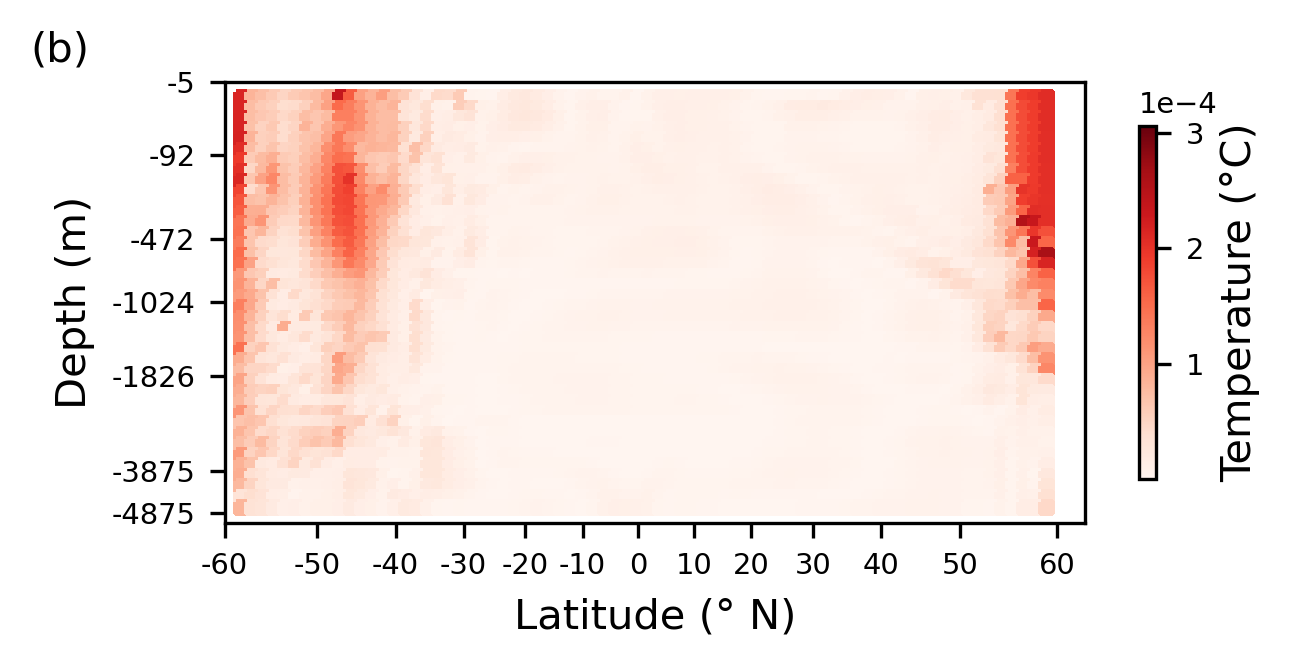

In [61]:
ig, ax, im = rfplt.plot_xconst_crss_sec(
    Av_AbsError[:,:,:], 
    'Averaged Absolute Errors', 
    x_coord,
    MITGCM_ds['X'].values,
    MITGCM_ds['Y'].values, 
    MITGCM_ds['Z'].values,
    text='(b)', 
    title=None,
    min_value=0.0,
    max_value=0.000306, 
    cmap='Reds',
    cbar_label=cbar_label, 
    Sci=True
)

Plotting the difference between this and the control run, with areas shaded in red indicating where the error has increased as a consequence of withholding information about the vertical structure, and blue indicating areas where the predictions are improved.

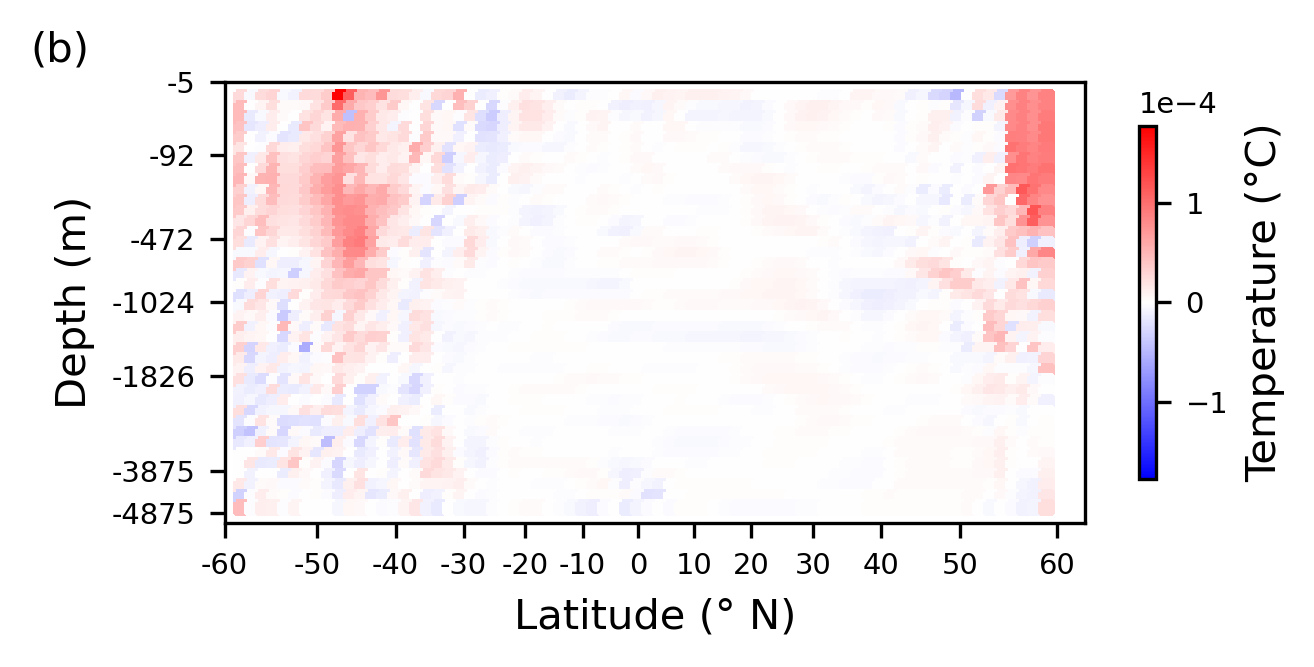

In [62]:
#Plot x cross section of difference between cntrl and exp
fig, ax, im = rfplt.plot_xconst_crss_sec(Av_AbsError[:,:,:]-Cntrl_Av_AbsError, 'Diff in Averaged Absolute Errors with Control Run', x_coord,
                                         MITGCM_ds['X'].values, MITGCM_ds['Y'].values, MITGCM_ds['Z'].values,
                                         text='(b)', title=None, min_value=None, max_value=None, diff=True,
                                         cbar_label=cbar_label, Sci=True)
#plt.savefig(rootdir+'PLOTS/'+model_name+'/'+exp_name+'_AvAbsErrors_DiffwCntrl_x'+str(x_coord)+'.eps', bbox_inches = 'tight', pad_inches = 0.1, format='eps')

The horizontal (U and V) components of the currents directly drive horizontal advection of temperature. They are also indirectly related to horizontal diffusion, as this is increased in regions of high currents and steep gradients. As such, we would expect that suppressing information about the horizontal currents would cause increases in error in regions where horizontal advection and horizontal diffusion is high. However, again, we note that this region of increased error is one where many processes are present, and the increased errors seen also coincide, to a lesser extent, with regions of high vertical processes (advection, diffusion, and convection), which is less in line with our physical understanding. Here, errors appear more closely matched to the horizontal processes, and so a reasonable interpretation is that the model here is behaving as expected, 

## Summary
-  There has been much recent interest in developing data-driven models for weather and climate predictions. However, there are open questions regarding their generalizability and robustness, highlighting a need to better understand how they make their predictions. In particular, it is important to understand whether data-driven models learn the underlying physics of the system against which they are trained, or simply identify statistical patterns without any clear link to the underlying physics. 
- In this notebook, we run a sensitivity analysis of a regression-based model of ocean temperature, trained against simulations from a 3D ocean model setup in a very simple configuration. 
- We show that the regressor heavily bases its forecasts on, and is dependent on, variables known to be key to the physics such as currents and density. By contrast, the regressor does not make heavy use of inputs such as location, which have limited direct physical impacts. 
- The model requires nonlinear interactions between inputs in order to show any meaningful skill—in line with the highly nonlinear dynamics of the ocean. Further analysis interprets the ways certain variables are used by the regression model. 
- We see that information about the vertical profile of the water column reduces errors in regions of convective activity, and information about the currents reduces errors in regions dominated by advective processes. 
- Our results demonstrate that even a simple regression model is capable of learning much of the physics of the system being modeled. We expect that a similar sensitivity analysis could be usefully applied to more complex ocean configurations.

## Additional information
**Dataset**: Malhotra, Garima, Pinto-Veizaga, Daniela, & Pena, Jorge. (2023). Reproducible Challenge - Team 3 - Sensitivity analysis- Models. https://doi.org/10.5281/zenodo.7954232 - Version 1

Furner, Rachel. (2021). MITgcm Dataset for paper: Sensitivity analysis of a data-driven model of ocean temperature (v1.1) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.7919172 - Version 1.1


**Codebase**: https://github.com/garimamalhotra/repro-challenge-team-3

**License**: The code in this notebook is licensed under the MIT License. The Environmental Data Science book is licensed under the Creative Commons by Attribution 4.0 license. See further details [here](https://github.com/alan-turing-institute/environmental-ds-book/blob/master/LICENSE.md).

**Contact**: If you have any suggestion or report an issue with this notebook, feel free to [create an issue](https://github.com/garimamalhotra/repro-challenge-team-3) or send email to the authors: garima.malhotra@colorado.edu, daniela.pinto@berkeley.edu, jorge_eduardo2894@hotmail.com

In [63]:
from datetime import date
print(f'Last tested: {date.today()}')

Last tested: 2023-05-22
